<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2022

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 3 <br>
American Sign Language Image Classification
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
			<br/><br/>
Deadline:  
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
<br>
<font size=3 color=grey>
Author: Sayeh Jarollahi
</font>
                <br/>
    </div>

In [ ]:
# Set your student number
student_number = 99101105
Name = 'Abolfazl'
Last_Name = 'Eshagh'
# some parts of this code were prepared using some help from github copilot

In this question, you will train a neural network for classifying sign language images. The American  Sign Language (ASL) dataset consists of 2515 images from different numbers and alphabets. The images are in RGB format and are not the same size. The dataset is classified into 36 classes (10 numbers and 26 alphabets). 

You will need to train a model to classify this dataset into different categories. You are allowed to use MLP as well as CNN networks. 

**Grading Policy:** For a full mark on this assignment, your notebook should be completely runnable by the TA. Additionally, you must reach an accuracy of %96 on the test data.

It is highly recommended to use google colab and utilize its GPUs. However, if you want to run the notebook locally, you can reach and download the dataset in this [link](https://drive.google.com/file/d/11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5/view?usp=share_link).



## Setup


In [3]:
# !pip install os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os

from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
# from q1_helper_code import get_files

#########################################
#                                       #
#  import other necessery packages here #
#                                       #
#########################################

In [4]:
# NOTE: It is highly recommended to use colab GPUs!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Download and unzip the dataset


In [5]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5" -O asl_dataset.zip && rm -rf /tmp/cookies.txt
! unzip asl_dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: asl_dataset/0/hand2_0_dif_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0

In [6]:
main_dir = "asl_dataset/asl_dataset"
class_dirs = os.listdir(main_dir)
# print(class_dirs)

## Transform 

Data transformation is the process of converting data from one format or structure into another format or structure. Transformers change pixel values but still keep almost the whole information of the image.[source](https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4) You can read more about them in the mentioned source. 

You are going to implement two different transformers from scratch. These transformers will be used once the data is loaded. 

### Resize 
This transformer recieves a tensor (3\*x\*y) and returns a tensor with shape (3\*size\*size)

In [12]:

class Resize(object):
    def __init__(self, size=50):
        self.size = size
    def __call__(self, x):
        '''
        This function recieves a tensor and applies the resizing on that and returns that tensor
        '''
        result = torch.zeros(3, self.size, self.size)
        for i in range(self.size):
            for j in range(self.size):
                result[0][i][j] = x[0][int(i / self.size * x.shape[1])][int(j / self.size * x.shape[2])]
                result[1][i][j] = x[1][int(i / self.size * x.shape[1])][int(j / self.size * x.shape[2])]
                result[2][i][j] = x[2][int(i / self.size * x.shape[1])][int(j / self.size * x.shape[2])]
        return result

        # result = torch.zeros(3, self.size, self.size)
        # for i in range(3):
        #     for j in range(self.size):
        #         for k in range(self.size):
        #             result[i][j][k] = x[i][j][k]
        # return result
        # result = torch.zeros(3, self.size, self.size)
        # for i in range(3):
        #     result[i] = torch.from_numpy(cv2.resize(x[i].numpy(), (self.size, self.size)))
        # return result
#This transform is helpful to decrease the number of channels, so the training gets faster.

### GrayScale
This transform is helpful to decrease the number of channels, so the training gets faster. 

Feel free to add args to functions or change them if you need to!

In [8]:


class GrayScale(object):
    def __init__(self):
        pass
    #is performed on x=Image.open(...)
    def __call__(self, x):
      # transform = transforms.Grayscale()
      # img = transform(x)
      # return img
      '''
      This function recieves a tensor and applies the grayscale on that and returns that tensor
      '''
      result = torch.zeros(1, x.shape[1], x.shape[2])
      for i in range(x.shape[1]):
          for j in range(x.shape[2]):
              result[0][i][j] = 0.2989 * x[0][i][j] + 0.5870 * x[1][i][j] + 0.1140 * x[2][i][j]
      return result

## Load Data and compose transforms 
You can combine Transforms using the **compose** method in the torchvision.transforms library.

In [9]:

transform = transforms.Compose([
    transforms.ToTensor(),
    Resize(),
    GrayScale()
])

Plot one random sample from each class of the datset:

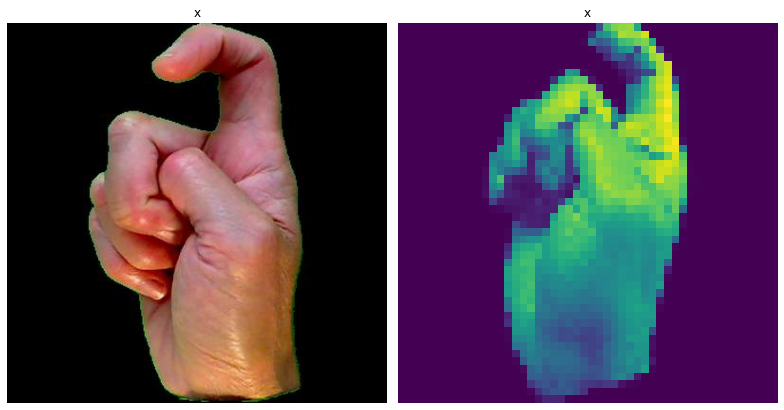

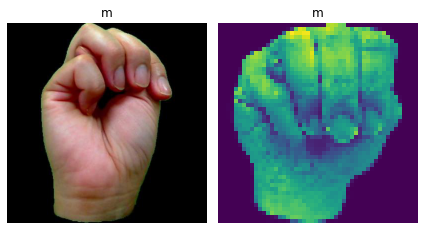

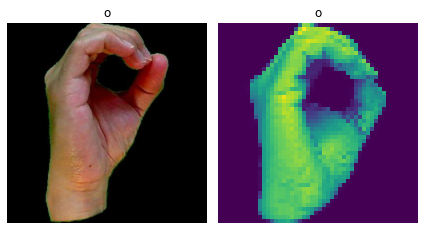

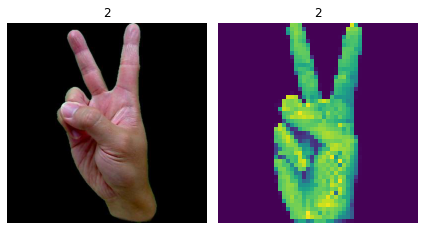

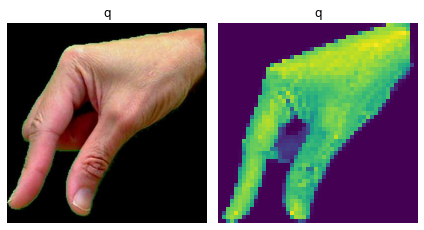

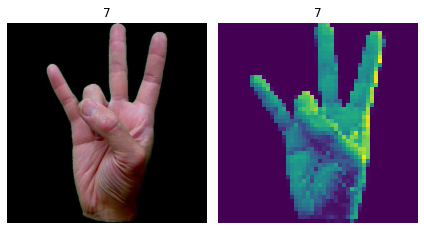

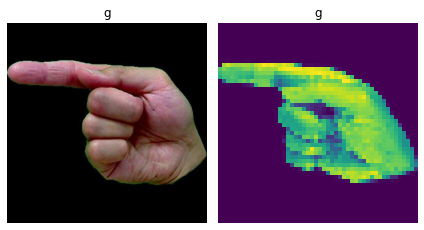

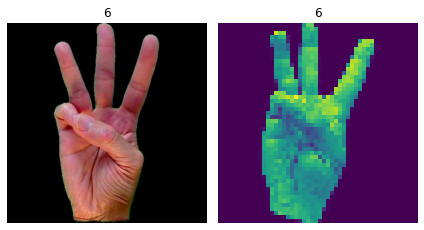

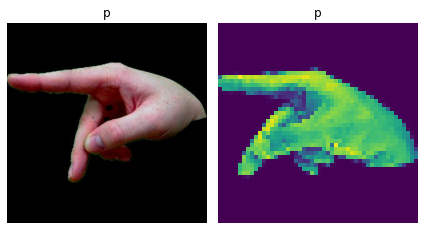

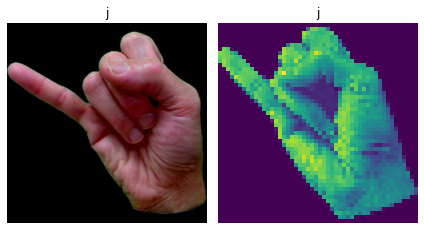

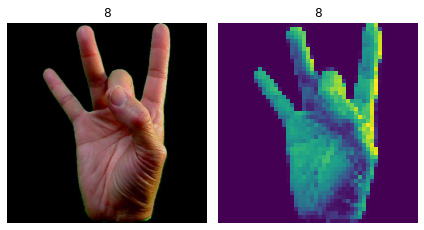

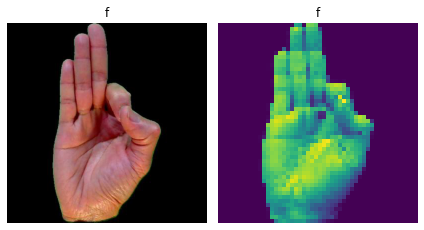

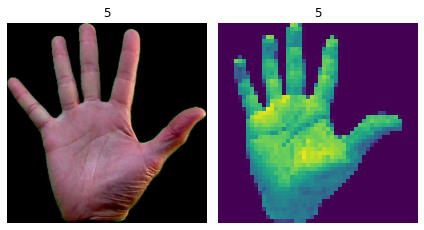

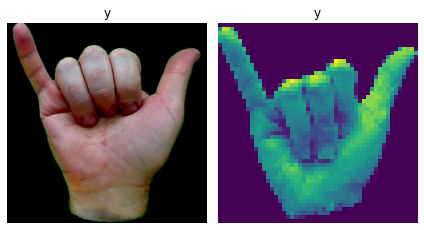

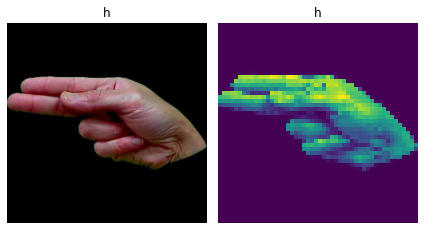

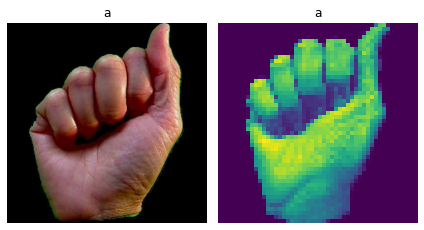

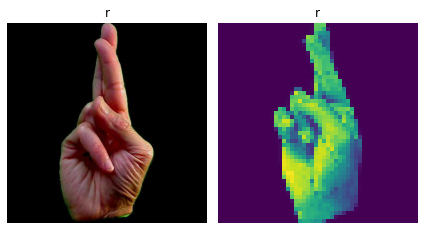

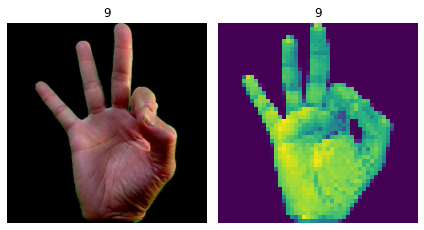

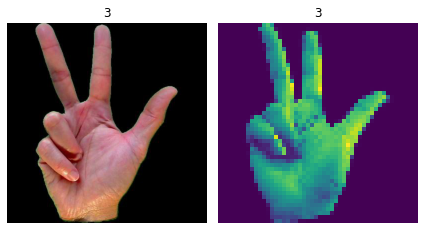

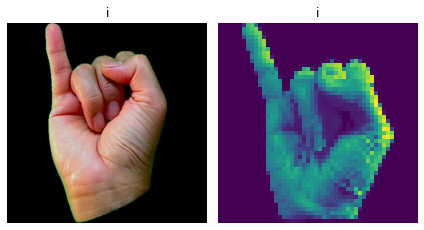

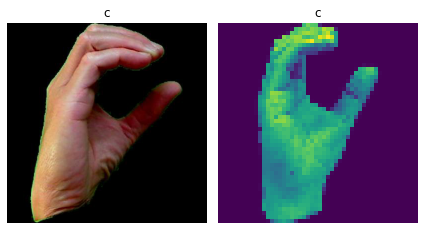

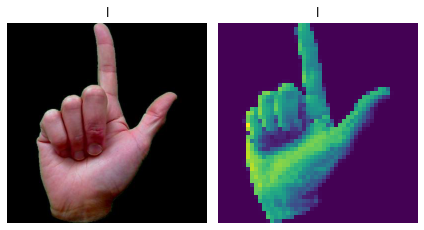

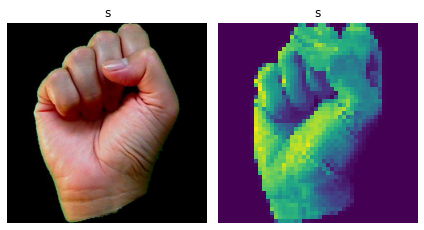

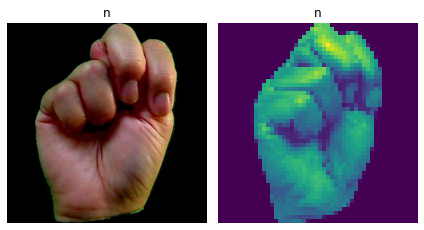

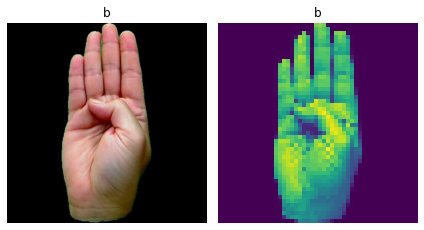

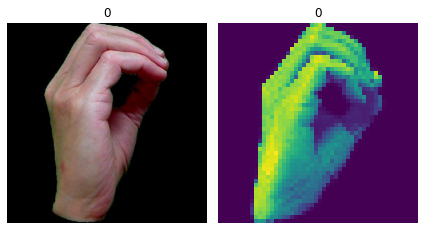

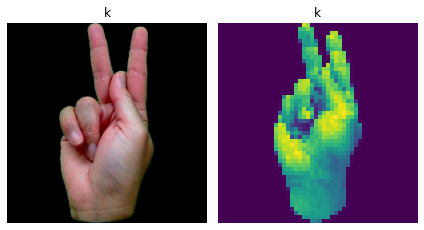

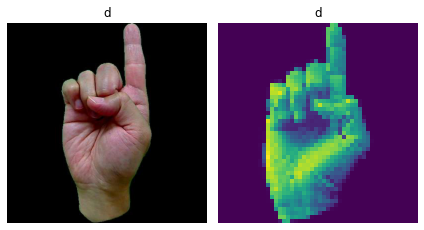

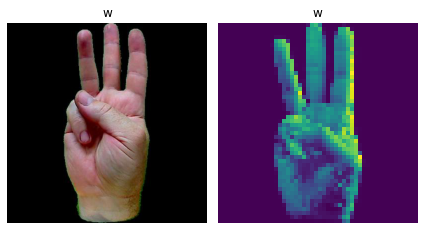

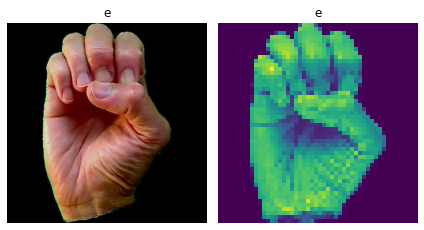

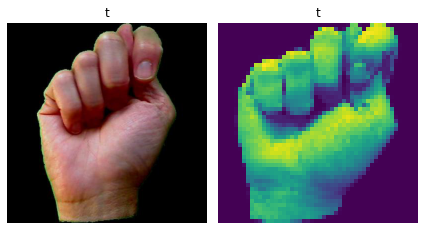

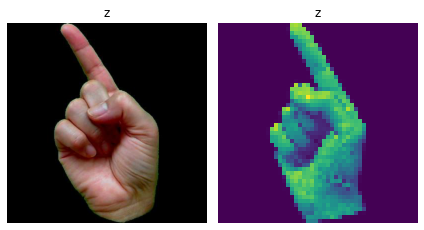

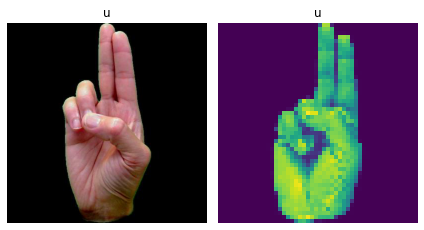

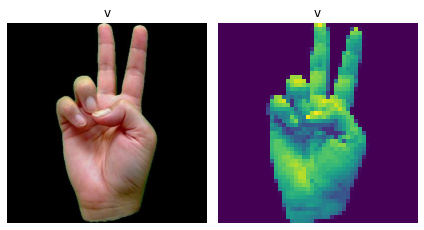

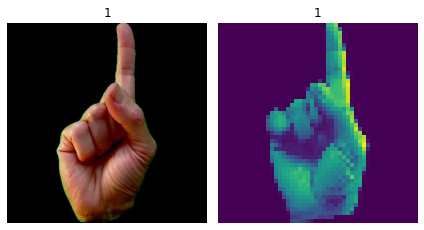

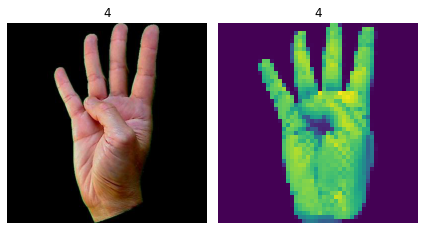

In [13]:
# '''
# Hint:
# Get two random samples from files in each directory and use subplot to add those
# images to the plot. 
# Use previously defined transform to test your transforms
# '''

plt.figure(figsize=(11,11))
for i in range(len(class_dirs)):
    for j in range(2):
        plt.subplot(1, 2, j + 1)
        img_path = main_dir + "/" + class_dirs[i] + "/" + os.listdir(main_dir + "/" + class_dirs[i])[random.randint(0, len(os.listdir(main_dir + "/" + class_dirs[i])) - 1)]
        img = Image.open(img_path)
        plt.title(img_path.split('/')[2])
        plt.axis('off')
        if j == 0:
            plt.imshow(img)
        else:
            plt.imshow(transform(img)[0])
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(11,11))
# for i in range(len(class_dirs)):
#     for j in range(2):
#         plt.subplot(1, 2, j + 1)
#         img_path = main_dir + "/" + class_dirs[i] + "/" + os.listdir(main_dir + "/" + class_dirs[i])[random.randint(0, len(os.listdir(main_dir + "/" + class_dirs[i])) - 1)]
#         img = Image.open(img_path)
#         plt.title(img_path.split('/')[2])
#         plt.axis('off')
#         if j == 0:
#             plt.imshow(img)
#         else:
#             plt.imshow(transform(img)[0])
#     plt.tight_layout()
#     plt.show()




# plt.tight_layout()
# plt.show()

# for i in range(5):
#     for j in range(2):
#         plt.subplot(5, 4, i*4 + j + 1)
#         img_path = main_dir + "/" + class_dirs[i] + "/" + os.listdir(main_dir + "/" + class_dirs[i])[random.randint(0, len(os.listdir(main_dir + "/" + class_dirs[i])) - 1)]
#         if j == 0 :
#           img = Image.open(img_path)
#         plt.title(img_path.split('/')[2])
#         plt.axis('off')
#         if j == 0:
#             plt.imshow(img)
#         else:
#             plt.imshow(transform(img)[0])

# plt.tight_layout()
# plt.show()
# for i in range(5):
#     for j in range(2):
#         plt.subplot(5, 4, i*4 + j + 1)
#         img_path = main_dir + "/" + class_dirs[i+5] + "/" + os.listdir(main_dir + "/" + class_dirs[i+5])[random.randint(0, len(os.listdir(main_dir + "/" + class_dirs[i+5])) - 1)]
#         if j == 0 :
#           img = Image.open(img_path)
#         plt.title(img_path.split('/')[2])
#         plt.axis('off')
#         if j == 0:
#             plt.imshow(img)
#         else:
#             plt.imshow(transform(img)[0])

# # plt.tight_layout()
# plt.show()
# for i in range(len(class_dirs)):
#     plt.subplot(6, 6, i + 1)
#     random_file = random.choice(os.listdir(main_dir + "/" + class_dirs[i]))
#     img = Image.open(main_dir + "/" + class_dirs[i] + "/" + random_file)
#     plt.imshow(img)
#     plt.title(class_dirs[i])
#     plt.axis("off")
# plt.show()

# plt.figure(figsize=(11,11))
# for i in range(len(class_dirs)):
#     plt.subplot(6, 6, i + 1)
#     random_file = random.choice(os.listdir(main_dir + "/" + class_dirs[i]))
#     img = Image.open(main_dir + "/" + class_dirs[i] + "/" + random_file)
#     img = transform(img)
#     plt.imshow(img[0])
#     plt.title(class_dirs[i])
#     plt.axis("off")
# plt.show()


# for i in range(len(class_dirs)):
#     random_file = random.choice(os.listdir(main_dir + "/" + class_dirs[i]))
#     random_file = main_dir + "/" + class_dirs[i] + "/" + random_file
#     img = Image.open(random_file)
#     img = transform(img)
#     plt.subplot(6,6,i+1)
#     plt.imshow(img[0], cmap='gray')
#     plt.title(class_dirs[i])
#     plt.axis('off')
# plt.show()
# for i, directory in enumerate(class_dirs):
#     # name of all files in the directory
#     files_name = os.listdir(f"{main_dir}/{directory}")
#     # get two random files
#     random_files = random.sample(files_name, 2)
#     # print(file for file in random_files)
#     # get the path of the two random files
#     random_files_path = [f"{main_dir}/{directory}/{file}" for file in random_files]
#     # read the two random files
#     # print([Image.open(file) for file in random_files_path])
#     # print([file for file in random_files_path])
#     random_files = [Image.open(file) for file in random_files_path]
#     # apply the transform to the two random files
#     random_files_check = random_files
#     random_files = [transform(file) for file in random_files]
#     # random_files = [transform2(file) for file in random_files_hold]
#     # plot the two random files
#     transform2 = transforms.Compose([transforms.ToTensor()])
#     random_files_check = [transform2(file) for file in random_files_check]
#     # tensor = transform(img)
#     for j, file in enumerate(random_files):
#       if 4*i + j + 1 < 25:
#       # plt.subplot()
#         plt.subplot(6, 4, 4*i + j + 1)
#         plt.imshow(file[0], cmap='gray')
#         plt.title(directory)
#         plt.axis('off')
#     for j, file in enumerate(random_files_check):
#       if 4*i + j + 1 < 25:
#       # plt.subplot()
#         plt.subplot(6, 4, 4*i + j + 1)
#         plt.imshow(file[0], cmap='gray')
#         plt.title(directory)
#         plt.axis('off')
# plt.show()

## Create Dataset 
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. [from [Pytorch Documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)] 

In this section, you will implement a custom dataset which gets address of files and loads them as needed. 

In [14]:

class ASLDataset(Dataset):
    def __init__(self, files_address:list, transform=transform):
# Hint: you can use the get_files function to get the files address
        self.files_address = files_address
        self.transform = transform
        self.classes = None
        self.class_to_idx = None
        self.idx_to_class = None
        self.class_to_files = None
        self.class_to_files_address = None
        self.class_to_files_name = None
        #############################
        #         Code here         #
        #############################
        # pass

    def __len__(self):
        # returns length of the data
        return len(self.files_address)

        # return 0

    def __getitem__(self, idx):
        # Hint: load image from files_address and the label from name of the directory
        # Remember to apply transforms!
        # image = None
        # label = None
        image = Image.open(self.files_address[idx])
        label = self.files_address[idx].split('/')[2]
        image = self.transform(image)
        return image, label
        #############################
        #         Code here         #
        #############################

In [15]:
def get_files(main_dir='asl_dataset/asl_dataset'):
    files_addr , lbls = [], []
    for dir in os.listdir(main_dir):
        lbl = int(dir) if dir.isdigit() else (ord(dir) - 87)
        addrs = [f'{main_dir}/{dir}/{file_name}' for file_name in os.listdir(f'{main_dir}/{dir}')]
        files_addr.extend(addrs)
        lbls.extend([lbl]*len(addrs))
    return files_addr, lbls

files_addr, labels = get_files()
# print(len(labels), len(files_addr))

## Create Datasets  

First split data to train, validation and test using the `train_test_split funciton`. Remember to shuffle data. Then create ASLDataset for each part of data. 

In [16]:
# #############################
# #         Code here         #
# #############################
# x_train, x_test, y_train, y_test = None, None, None, None
# x_train, x_val, y_train, y_val = None, None, None, None
# train_dataset = None
# val_dataset = None
# test_dataset = None

x_train, x_test, y_train, y_test = train_test_split(files_addr, labels, test_size=0.2, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)
train_dataset = ASLDataset(x_train)
val_dataset = ASLDataset(x_val)
test_dataset = ASLDataset(x_test)
# print(len(train_dataset), len(val_dataset), len(test_dataset))


Use datasets to create DataLoader from `torch.utils.DataLoader` class

Note: You should make `shuffle=True` for the training dataLoader, so in each epoch the data reshuffles. 

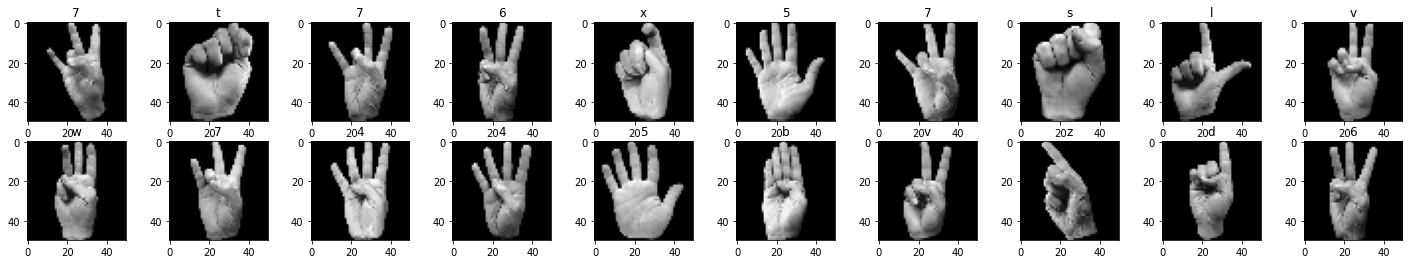

In [17]:
# num_threads = 4

# #############################
# #         Code here         #
# #############################

# train_loader = None
# val_loader = None
# test_loader = None

num_threads = 4
batch_size = 64
# train_loader = None
# val_loader = None
# test_loader = None

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

"""## Visualize Dataloader

Visualize a batch of data from Dataloader. 
"""

# #############################
# #         Code here         #
# #############################
# dataiter = None
# images, labels = None, None
# images = None
# labels = None
# plt.figure(figsize=(25, 4))
# for idx in np.arange(20):
#     plt.subplot(2, 20/2, idx+1)
#     plt.imshow(images[idx].numpy().squeeze(), cmap='gray')
#     plt.title(str(labels[idx].item()))

dataiter = iter(train_dataloader)
images, labels = dataiter.__next__()
images = images
labels = labels
plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    plt.subplot(2, 20/2, idx+1)
    plt.imshow(images[idx].numpy().squeeze(), cmap='gray')
    plt.title(str(labels[idx]))


# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)
# print(len(train_loader), len(val_loader), len(test_loader))
# '''
# Create Dataloader
# After creating the dataset, we need to create a dataloader. Dataloader is an iterator that provides all the data samples.
# '''
# def get_dataloader(files_address, batch_size=64):
#     dataset = ASLDataset(files_address, transform=transform)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#     return dataloader

# '''
# Create Dataloader
# After creating the dataset, we need to create a dataloader. Dataloader is an iterator that provides all the data samples.
# '''
# train_loader = get_dataloader(x_train)
# val_loader = get_dataloader(x_val)
# test_loader = get_dataloader(x_test)
# print(len(train_loader), len(val_loader), len(test_loader))

## Define Model 

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)

        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 128)
        self.fc7 = nn.Linear(128, 256)
        self.fc8 = nn.Linear(256, 512)
        self.fc9 = nn.Linear(512, 1024)
        self.fc10 = nn.Linear(1024, 26)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):

      def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.conv1(x)
        # x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        # x = F.relu(x)
        x = self.pool2(x)
        x = x.view(x.shape[0], -1)
        # x = self.fc1(x)
        # x = F.relu(x)
        x = self.dropout(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc3(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc4(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc5(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc6(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc7(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc8(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc9(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc10(x)
        # return x
        return x

        # # define forward pass
        # x = x.view(x.shape[0], -1)
        # x = self.dropout(nn.F.relu(self.fc1(x)))
        # x = self.dropout(nn.F.relu(self.fc2(x)))
        # x = self.dropout(nn.F.relu(self.fc3(x)))
        # x = self.dropout(nn.F.relu(self.fc4(x)))

        # x = self.dropout(nn.F.relu(self.fc5(x)))
        # x = self.dropout(nn.F.relu(self.fc6(x)))
        # x = self.dropout(nn.F.relu(self.fc7(x)))
        # x = self.dropout(nn.F.relu(self.fc8(x)))
        # x = self.dropout(nn.F.relu(self.fc9(x)))
        # # x = F.log_softmax(self.fc10(x), dim=1)
        # # x = self.fc10(x)

        # return x
        # # define forward pass
        # x = x.view(x.shape[0], -1)
        # x = nn.functional.relu(self.fc1(x.view(x.shape[0], -1)))
        # x = self.dropout(x)
        # x = nn.functional.relu(self.fc2(x.view(x.shape[0], -1)))
        # x = self.dropout(x)
        # x = nn.functional.relu(self.fc3(x.view(x.shape[0], -1)))
        # x = self.dropout(x)
        # x = nn.functional.relu(self.fc4(x.view(x.shape[0], -1)))
        # x = self.dropout(x)

        # x = nn.functional.relu(self.fc5(x.view(x.shape[0], -1)))
        # x = self.dropout(x)
        # x = nn.functional.relu(self.fc6(x.view(x.shape[0], -1)))
        # x = self.dropout(x)
        # x = nn.functional.relu(self.fc7(x.view(x.shape[0], -1)))
        # x = self.dropout(x)
        # x = nn.functional.relu(self.fc8(x.view(x.shape[0], -1)))
        # x = self.dropout(x)
        # x = nn.functional.relu(self.fc9(x.view(x.shape[0], -1)))
        # x = self.dropout(x)
        # x = self.fc10(x)
        # return x

model = Net()
print(model)


# # class ASLModel(nn.Module):
# #     def __init__(self, in_channels, num_classes):
# #         super().__init__()
# #         self.network = nn.Sequential(
# #             #############################
# #             #         Code here         #
# #             #############################

# #             )
        
# #     def forward(self, xb):
# #         #############################
# #         #         Code here         #
# #         #############################
# #         pass

# class ASLModel(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
#         self.network = nn.Sequential(
#             #############################
#             #         Code here         #
#             #############################
#             nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Flatten(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, num_classes)
#             )

#     def forward(self, xb):
#         #############################
#         #         Code here         #
#         #############################
#         return self.network(xb)


# class ASLModel(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Flatten(),
#             nn.Linear(512 * 2 * 2, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, num_classes)
#             )
        
#     def forward(self, xb):
#         return self.network(xb)

# class ASLModel(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super(ASLModel, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#         self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#         self.fc1 = nn.Linear(128 * 13 * 13, 1024)
#         self.fc2 = nn.Linear(1024, num_classes)
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = x.reshape(x.shape[0], -1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# class ASLModel(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
#             nn.Linear(512*4*4, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, num_classes)
#             #############################
#             #         Code here         #
#             #############################

#             )
        
#     def forward(self, xb):
#         return self.network(xb)
#         #############################
#         #         Code here         #
#         #############################
#         # pass
'''
Create model
'''
# model = None
# model = ASLModel(3, 29)
# model = ASLModel(3, 29)
# model.to(device)
# print(model)
'''
Set device
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# device = None
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
'''
Set loss function and optimizer
'''
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# f_loss = None
# # optimizer = None
# f_loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=512, bias=True)
  (fc9): Linear(in_features=512, out_features=1024, bias=True)
  (fc10): Linear(in_features=1024, out_features=26, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [19]:
# in_channels = 3 
# num_classes = 36
# model = ASLModel(in_channels, num_classes).to(device)
images, labels = dataiter.__next__()
images = images

## Define optimizer, Criterion and other parameters 


In [ ]:
# # #############################
# # #         Code here         #
# # #############################
# # # loss = None
# # # optimizer = None

# # loss = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# f_loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# # # Set parameters and hyper parameters
# # batch_size = None
# # learning_rate = None 
# # input_size = None 

# batch_size = 64
# learning_rate = 0.001
# input_size = 3

In [20]:
epochs = 30
train_losses, test_losses = [], []
def backward(self, grad_output):
    return grad_output
for e in range(epochs):

    running_loss = 0
    for images, labels in train_dataloader:
        # images = None
        optimizer.zero_grad()
        # output = model(images)
        output = model.forward(images)
        # output, x = model(inputs)
        print(output)
        loss = criterion(output, labels)
        loss = criterion(output, labels)
        # loss = nn.CrossEntropyLoss(output, labels)
        # loss = torch.tensor(loss, dtype=torch.float32)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images, labels in val_dataloader:
                # images = None
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(train_dataloader))
        test_losses.append(test_loss/len(val_dataloader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_dataloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(val_dataloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(val_dataloader)))

"""## Plot the loss and accuracy

Plot the loss and accuracy.
"""

# #############################
# #         Code here         #
# #############################
# plt.plot(train_losses, label='Training loss')
# plt.plot(test_losses, label='Validation loss')
# plt.legend(frameon=False)

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)


 # def train_val(model, train_loader, val_loader, optimizer, loss_fn, epochs):
# #     train_loss_arr = []
# #     train_acc_arr = []
# #     val_loss_arr = []
# #     val_acc_arr = []
# #     for epoch in range(epochs):
# #         train_loss = 0
# #         train_acc = 0
# #         model.train()
# #         for x, y in train_loader:
# #             x = x.to(device)
# #             y = y.to(device)
# #             optimizer.zero_grad()
# #             out = model(x)
# #             loss = loss_fn(out, y)
# #             loss.backward()
# #             optimizer.step()
# #             train_loss += loss.item()
# #             train_acc += (out.argmax(1) == y).sum().item()
# #         train_loss /= len(train_loader)
# #         train_acc /= len(train_loader.dataset)
# #         train_loss_arr.append(train_loss)
# #         train_acc_arr.append(train_acc)
# #         val_loss = 0
# #         val_acc = 0
# #         model.eval()
# #         with torch.no_grad():
# #             for x, y in val_loader:
# #                 x = x.to(device)
# #                 y = y.to(device)
# #                 out = model(x)
# #                 loss = loss_fn(out, y)
# #                 val_loss += loss.item()
# #                 val_acc += (out.argmax(1) == y).sum().item()
# #         val_loss /= len(val_loader)
# #         val_acc /= len(val_loader.dataset)
# #         val_loss_arr.append(val_loss)
# #         val_acc_arr.append(val_acc)
# #         print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
# #     return train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr

# def train_val(model, train_loader, val_loader, optimizer, loss_fn, epochs):
#     train_loss_arr = []
#     train_acc_arr = []
#     val_loss_arr = []
#     val_acc_arr = []
#     for epoch in range(epochs):
#         train_loss = 0
#         train_acc = 0
#         model.train()
#         for x, y in train_loader:
#             x = torch.tensor(x)
#             y = torch.tensor(y)
#             x = x.to(device)
#             y = y.to(device)
#             optimizer.zero_grad()
#             out = model(x)
#             loss = loss_fn(out, y)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             train_acc += (out.argmax(1) == y).sum().item()
#         train_loss /= len(train_loader)
#         train_acc /= len(train_loader.dataset)
#         val_loss = 0
#         val_acc = 0
#         model.eval()
#         for x, y in val_loader:
#             x = torch.tensor(x)
#             y = torch.tensor(y)
#             x = x.to(device)
#             y = y.to(device)
#             out = model(x)
#             loss = loss_fn(out, y)
#             val_loss += loss.item()
#             val_acc += (out.argmax(1) == y).sum().item()
#         val_loss /= len(val_loader)
#         val_acc /= len(val_loader.dataset)
#         train_loss_arr.append(train_loss)
#         train_acc_arr.append(train_acc)
#         val_loss_arr.append(val_loss)
#         val_acc_arr.append(val_acc)
#         print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
#     return train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr





# # # # best_model = None
# # # # best_acc = 0

# # # # def train_val (model, trainloader, val_loader, f_loss, optimizer, n_epochs, device = device):
# # # #     train_loss_arr, val_loss_arr = [], []
# # # #     train_acc_arr, val_acc_arr = [], []  
# # # #     for epoch in range(n_epochs):
# # # #         train_loss, val_loss = 0, 0
# # # #         model.train()
# # # #         #############################
# # # #         #         Code here         #
# # # #         #############################
# # # #         ## Hint: Loop throught train_loader, get images with their labels and train the model
# # # #         ## Hint 2: To update train_loss inside the loop use "train_loss += batch_loss * batch_size""
# # # #         ## Hint 3: To update train_acc get the predicted label of each training data and compare with the real label
    
    
# # # #         model.eval()
# # # #         #############################
# # # #         #         Code here         #
# # # #         #############################
# # # #         ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
# # # #         ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
# # # #         ## Hint 3: you have to keep the best model in the best_model variable to use it in the testing phase


# # # #         train_loss /= len(train_loader.dataset)
# # # #         val_loss /= len(val_loader.dataset)
# # # #         train_loss_arr.append(train_loss)
# # # #         val_loss_arr.append(val_loss)
# # # #         #############################
# # # #         #         Code here         #
# # # #         #############################
# # # #         # append accuracy of train and valid to the lists

# # # #         print(f"[Epoch {epoch}]\t"
# # # #             f"Train Loss: {train_loss:.3f}\t"
# # # #             f"Validation Loss: {val_loss:.3f}")
# # # #     return train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr

# # # def train_val (model, trainloader, val_loader, f_loss, optimizer, n_epochs, device = device):
# # #     train_loss_arr, val_loss_arr = [], []
# # #     train_acc_arr, val_acc_arr = [], []  
# # #     for epoch in range(n_epochs):
# # #         train_loss, val_loss = 0, 0
# # #         model.train()
# # #         #############################
# # #         #         Code here         #
# # #         #############################
# # #         ## Hint: Loop throught train_loader, get images with their labels and train the model
# # #         ## Hint 2: To update train_loss inside the loop use "train_loss += batch_loss * batch_size""
# # #         ## Hint 3: To update train_acc get the predicted label of each training data and compare with the real label
# # #         for batch_idx, (data, target) in enumerate(train_loader):
# # #             data, target = data.to(device), target.to(device)
# # #             optimizer.zero_grad()
# # #             output = model(data)
# # #             batch_loss = loss(output, target)
# # #             batch_loss.backward()
# # #             optimizer.step()
            
# # #             train_loss += batch_loss.item() * data.size(0)
# # #             _, pred = torch.max(output, 1)
# # #             correct_tensor = pred.eq(target.data.view_as(pred))
# # #             accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
# # #             train_acc += accuracy.item() * data.size(0)
            
# # #         model.eval()
# # #         #############################
# # #         #         Code here         #
# # #         #############################
# # #         ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
# # #         ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
# # #         ## Hint 3: you have to keep the best model in the best_model variable to use it in the testing phase
# # #         for batch_idx, (data, target) in enumerate(val_loader):
# # #             data, target = data.to(device), target.to(device)
# # #             output = model(data)
# # #             batch_loss = loss(output, target)
            
# # #             val_loss += batch_loss.item() * data.size(0)
# # #             _, pred = torch.max(output, 1)
# # #             correct_tensor = pred.eq(target.data.view_as(pred))
# # #             accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
# # #             val_acc += accuracy.item() * data.size(0)
            
# # #         train_loss /= len(train_loader.dataset)
# # #         val_loss /= len(val_loader.dataset)
# # #         train_loss_arr.append(train_loss)
# # #         val_loss_arr.append(val_loss)
# # #         #############################
# # #         #         Code here         #
# # #         #############################
# # #         # append accuracy of train and valid to the lists
# # #         train_acc = train_acc / len(train_loader.dataset)
# # #         val_acc = val_acc / len(val_loader.dataset)
# # #         train_acc_arr.append(train_acc)
# # #         val_acc_arr.append(val_acc)
        
# # #         if val_acc > best_acc:
# # #             best_acc = val_acc
# # #             best_model = model
            
# # #         print(f"[Epoch {epoch}]\t"
# # #             f"Train Loss: {train_loss:.3f}\t"
# # #             f"Validation Loss: {val_loss:.3f}")
# # #     return train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr

# # def train_val (model, train_loader, val_loader, f_loss, optimizer, n_epochs, device = device):
# #     train_loss_arr, val_loss_arr = [], []
# #     train_acc_arr, val_acc_arr = [], []
# #     print("this is train loader" , [batch for batch in train_loader])  
# #     for epoch in range(n_epochs):
# #         train_loss, val_loss = 0, 0
# #         model.train()
# #         #############################
# #         #         Code here         #
# #         #############################
# #         ## Hint: Loop throught train_loader, get images with their labels and train the model
# #         ## Hint 2: To update train_loss inside the loop use "train_loss += batch_loss * batch_size""
# #         ## Hint 3: To update train_acc get the predicted label of each training data and compare with the real label
# #         for batch in train_loader:
# #             images, labels = batch
# #             images, labels = images.to(device), labels.to(device)
# #             y_pred = model(images)
# #             batch_loss = f_loss(y_pred, labels)
# #             train_loss += batch_loss.item() * batch_size
# #             optimizer.zero_grad()
# #             batch_loss.backward()
# #             optimizer.step()
# #         train_loss /= len(train_loader.dataset)
# #         model.eval()
# #         #############################
# #         #         Code here         #
# #         #############################
# #         ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
# #         ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
# #         ## Hint 3: you have to keep the best model in the best_model variable to use it in the testing phase
# #         for batch in val_loader:
# #             images, labels = batch
# #             images, labels = images.to(device), labels.to(device)
# #             y_pred = model(images)
# #             batch_loss = f_loss(y_pred, labels)
# #             val_loss += batch_loss.item() * batch_size
# #             pred = y_pred.argmax(dim=1, keepdim=True)
# #             correct += pred.eq(labels.view_as(pred)).sum().item()
# #         val_loss /= len(val_loader.dataset)
# #         train_loss_arr.append(train_loss)
# #         val_loss_arr.append(val_loss)
# #         #############################
# #         #         Code here         #
# #         #############################
# #         # append accuracy of train and valid to the lists
# #         train_acc_arr.append(correct / len(train_loader.dataset))
# #         val_acc_arr.append(correct / len(val_loader.dataset))
# #         if correct / len(val_loader.dataset) > best_acc:
# #             best_acc = correct / len(val_loader.dataset)
# #             best_model = model
# #         print(f"[Epoch {epoch}]\t"
# #             f"Train Loss: {train_loss:.3f}\t"
# #             f"Validation Loss: {val_loss:.3f}")
# #     return train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr

# # def train_val(model, trainloader, val_loader, f_loss, optimizer, n_epochs, device=device):
# #     train_loss_arr, val_loss_arr = [], []
# #     train_acc_arr, val_acc_arr = [], []
# #     for epoch in range(n_epochs):
# #         train_loss, val_loss = 0, 0
# #         model.train()
# #         #############################
# #         #         Code here         #
# #         #############################
# #         ## Hint: Loop throught train_loader, get images with their labels and train the model
# #         ## Hint 2: To update train_loss inside the loop use "train_loss += batch_loss * batch_size""
# #         ## Hint 3: To update train_acc get the predicted label of each training data and compare with the real label
# #         # we do not want to use data.to(device) because it will take a lot of time
# #         for batch_idx, (data, target) in enumerate(train_loader):
# #             print(type(data), type(target))
# #             data = data.to(device)
# #             optimizer.zero_grad()
# #             output = model(data)
# #             loss = f_loss(output, target)
# #             loss.backward()
# #             optimizer.step()
# #             train_loss += loss.item() * data.size(0)
# #             _, pred = torch.max(output, 1)
# #             correct_tensor = pred.eq(target.data.view_as(pred))
# #             correct = np.squeeze(correct_tensor.cpu().numpy())
# #             train_acc = np.sum(correct) / data.size(0)
# #             train_acc_arr.append(train_acc)
# #             if batch_idx % 100 == 0:
# #                 print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
# #                     epoch, batch_idx * len(data), len(train_loader.dataset),
# #                            100. * batch_idx / len(train_loader), loss.item()))
            
            

# #         model.eval()
        
# #         #############################
# #         #         Code here         #
# #         #############################
# #         ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
# #         ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
# #         ## Hint 3: you have to keep the best model in the best_model variable to use it in the testing phase
# #         for batch_idx, (data, target) in enumerate(val_loader):
# #             print(type(data), type(target))
# #             data = data.to(device)
# #             output = model(data)
# #             loss = f_loss(output, target)
# #             val_loss += loss.item() * data.size(0)
# #             _, pred = torch.max(output, 1)
# #             correct_tensor = pred.eq(target.data.view_as(pred))
# #             correct = np.squeeze(correct_tensor.cpu().numpy())
# #             val_acc = np.sum(correct) / data.size(0)
# #             val_acc_arr.append(val_acc)
# #             if batch_idx % 100 == 0:
# #                 print('Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
# #                     epoch, batch_idx * len(data), len(val_loader.dataset),
# #                            100. * batch_idx / len(val_loader), loss.item()))
                
                

# #         train_loss /= len(train_loader.dataset)
# #         val_loss /= len(val_loader.dataset)
# #         train_loss_arr.append(train_loss)
# #         val_loss_arr.append(val_loss)
        
# #         #############################
# #         #         Code here         #
# #         #############################
# #         # append accuracy of train and valid to the lists
# #         train_acc_arr.append(train_acc)
# #         val_acc_arr.append(val_acc)
# #         if val_acc > best_acc:
# #             best_acc = val_acc
# #             best_model = model
# #         print(f"[Epoch {epoch}]\t"
# #               f"Train Loss: {train_loss:.3f}\t"
# #               f"Validation Loss: {val_loss:.3f}")
# #     return train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr, best_model


None


TypeError: ignored

In [ ]:
# Call the train_val functiontrain_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_val(model, train_loader, val_loader, optimizer, f_loss, 10)
# model = ASLModel(1, 29).to(device)
model = ASLModel(3, 29).to(device)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
train_dataset = [(x, y) for x, y in train_dataset]
val_dataset = [(x, y) for x, y in val_dataset]


# train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_val(model, train_loader, val_loader, optimizer, f_loss, 10)
train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_val(model, train_loader, val_loader, optimizer, f_loss, 10)


<ipython-input-35-1019bfcfa3c2>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


ValueError: ignored

## Plot loss and accuracy

You must have one plot for loss according to epoch for train/val.

Also, another plot for accuracy according to epoch for train/val

NameError: ignored

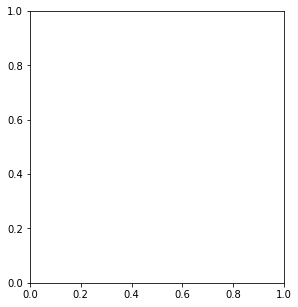

In [ ]:
#############################
#         Code here         #
#############################

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_arr, label='Train')
plt.plot(val_loss_arr, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_arr, label='Train')
plt.plot(val_acc_arr, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate model on the test dataset

Evaluate your best model on the test dataset. You should get accuracy above ***%96*** for a full-mark.

Remember to print the accuracy of model on the test dataset! 

In [ ]:
def evaluate(model, dataloader, device = device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
  
evaluate(best_model, test_dataloader)

NameError: ignored